In [1]:
import os, json, sys, csv, shutil
import pandas as pd
from sqlalchemy import create_engine
from PIL import Image
import pickle
import datetime
import utils.database as db
import utils.corpora as corp
import utils.fingerprints as finger

import operator
from scipy.sparse import csr_matrix
from sparse_som import *
import numpy as np
import re
import conf.conn as cfg
#from tqdm import tnrange, tqdm_notebook
%load_ext autoreload
%autoreload 2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import safe_indexing

#### BaseFunctions

In [2]:
#set wikipedia folder where dump json files are located
try:
    wikifilesdir = "F:/RESEARCH/TESE/corpora/wikifiles/01012018/json"
    os.chdir(wikifilesdir)
except:
    print('ERROR: ' +str(sys.exc_info()[0]))

#register file system json files in DB
def register():
    i = 0
    for subdir, dirs, files in os.walk(wikifilesdir):
    
        for file in files:
            if i % 5 == 0:
                print (str(i)+ ' files processed')
            #print (os.path.join(subdir, file))
            filepath = subdir + os.sep + file
            path = filepath.split(os.sep)[-3:]
            path = '/'.join(path)
            db.register_file(cfg, path)
            i = i + 1

    print ("DONE. %s files registered "% (i))

#process file system json files in DB and move file to processed destination folder
def process():
    limit = 100
    i = 0
    files = db.select_files(cfg, limit)
    processed_dir = wikifilesdir+'-processed'
    for file in files:
        if i % 5 == 0:
            print (str(i)+ ' files processed')
        path = file[1]
        file_id = file[0]
        filepath = wikifilesdir+'/'+path
        with open(filepath, 'r', encoding='utf-8') as fh:
            datafile=fh.readlines()
            db.process_file(cfg, datafile, file_id)
        fh.close();
        move_file(path, wikifilesdir, processed_dir)
        i = i + 1


def calculate_frequencies():
    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = 't'"
    data = pd.read_sql_query(sql, con=engine)
    word_counts_per_snippet = corp.get_word_counts_per_snippet(data)
    freqs = corp.get_frequencies(word_counts_per_snippet)
    vocabulary = corp.get_vocabulary(word_counts_per_snippet)
    return data, vocabulary, freqs, word_counts_per_snippet
        
def update_stats():
    data, vocabulary, freqs, word_counts_per_snippet = calculate_frequencies()
    db.update_stats(cfg, data, vocabulary)
    
def process_snippets(_limit):
    #tokenizer for snippets 
    #500 snippets -> 30 min
    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    sql = "select id, text from snippets"
    sql += "where length(text) > 100 and cleaned = 'f' and random() < 0.01 limit "+str(_limit)
    data = pd.read_sql_query(sql, con=engine)
    #print (data.shape)
    cleaned_texts = corp.clean_text(data, remove_stop_words=True, remove_punct=True, 
                   lemmas=True, remove_numbers=True, remove_spaces=True, remove_2letters_words=True, 
                   remove_apostrophe=True, method='spacy', spacy_disabled_components=['tagger', 'parser'])
    for text in cleaned_texts:
        print (text['id'])
        db.insert_cleaned_text(cfg, text['id'], text['snippet'])
        
def get_cleaned_data():
    conn_string = 'postgresql://postgres@localhost:5432/sparsenlp'
    engine = create_engine(conn_string)
    sql = "select id, cleaned_text from snippets where cleaned = 't'"
    dataframe = pd.read_sql_query(sql, con=engine)
    return dataframe
    

ERROR: <class 'FileNotFoundError'>


In [3]:
#register()
#process()
#get_tables_sizes()
#process_snippets(10)
#update_stats()

#engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
#sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = 't'"
#data = pd.read_sql_query(sql, con=engine)
#word_counts_per_snippet = corp.get_word_counts_per_snippet(data)
#print (word_counts_per_snippet[1])
#snippets_by_word = corp.get_snippets_by_word(word_counts_per_snippet)

#print (snippets_by_word['musician'])

#### Generate SOM

In [10]:
def generate_som():
    # setup SOM dimensions
    # Network height, width and unit dimensions
    H, W, N = 64, 64, 1000   
    #H, W, N = 128, 128, 500

    #som_type = 'SDSOM'
    som_type = 'BSOM'

    print ("getting data from  dataframe ...")
    df_train = get_cleaned_data()
    print ("get data done")

    train_data = df_train.cleaned_text

    print ("vectorizing texts ...")
    vectorizer = TfidfVectorizer(
                                lowercase=True,
                                #max_df=0.5, 
                                max_features=N,  
                                stop_words='english', 
                                use_idf=True)
    X = vectorizer.fit_transform(train_data)
    print ("vectorizing texts done")

    sufix = '_'+som_type+'_'+str(H)+'_'+str(N)+'_'+str(X.shape[0])

    #print (type(X))
    print (X.shape)
    #print(vectorizer.get_feature_names())
    
    # setup SOM network
    #som = Som(H, W, N, topology.RECT, verbose=True) # , verbose=True
    som = BSom(H, W, N, topology.RECT, verbose=True) # , verbose=True


    # reinit the codebook (not needed) #try to use minisom to init the codebook based on data
    som.codebook = np.random.rand(H, W, N).astype(som.codebook.dtype, copy=False)

    print ("I'm training the SOM, so take a break, relax and have some coffee ...")
    time1 = datetime.datetime.now()
    som.train(X)
    time2 = datetime.datetime.now()
    elapsedTime = time2 - time1
    minutes = divmod(elapsedTime.total_seconds(), 60)[0]

    db.insert_log(cfg, som_type+' trainning', sufix, minutes)
    print (type(som.codebook))


    print ("serializing files ...")
    np.save('./serializations/codebook'+sufix+'.npy', som.codebook)
    df_train.to_pickle('./serializations/dataframe'+sufix+'.pkl')
    np.savez('./serializations/X'+sufix+'.npz', data=X.data, indices=X.indices, indptr=X.indptr, shape=X.shape)

    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    #sql = "select id, cleaned_text, bmu_x, bmu_y from snippets where cleaned = 't'"
    sql = "select id, cleaned_text from snippets where cleaned = 't'"
    data = pd.read_sql_query(sql, con=engine)
    word_counts_per_snippet = corp.get_word_counts_per_snippet(data)
    #
    with open('./serializations/word_counts_per_snippet'+sufix+'.pkl', 'wb') as f:
        pickle.dump(word_counts_per_snippet, f)
    #
    snippets_by_word = corp.get_snippets_by_word(word_counts_per_snippet)
    with open('./serializations/snippets_by_word'+sufix+'.pkl', 'wb') as f:
        pickle.dump(snippets_by_word, f)


getting data from  dataframe ...
get data done
vectorizing texts ...


C:\Program Files\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


vectorizing texts done
(305554, 1000)
I'm training the SOM, so take a break and have some coffee ...
sorting indices
<class 'numpy.ndarray'>
serializing files ...


#### Generate Fingerprint

In [11]:
def create_fingerprint():
    H, W, N, rows = 64, 64, 1000, 305554    # Network height, width and unit dimensions
    som_type = 'BSOM'
    sufix = '_'+som_type+'_'+str(H)+'_'+str(N)+'_'+str(rows)


    codebook = np.load('./serializations/codebook'+sufix+'.npy')
    dataframe = pd.read_pickle('./serializations/dataframe'+sufix+'.pkl')
    loader = np.load('./serializations/X'+sufix+'.npz')
    print (' loading snippets_by_word'+sufix)   
    with open('./serializations/snippets_by_word'+sufix+'.pkl', 'rb') as handle:
        snippets_by_word = pickle.load(handle)
    print ('./serializations/snippets_by_word'+sufix+' load done')
    X = csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape=loader['shape'])
    print (X.shape)

    word = 'dog'
    time1 = datetime.datetime.now()
    a_original, a_sparse = finger.create_fingerprint(word, dataframe, snippets_by_word, codebook, X, H, W, sufix)
    time2 = datetime.datetime.now()
    elapsedTime = time2 - time1
    minutes = divmod(elapsedTime.total_seconds(), 60)[0]
    db.insert_log(cfg, 'create fingerprint', sufix, minutes)

 loading snippets_by_word_BSOM_64_1000_305554
./serializations/snippets_by_word_BSOM_64_1000_305554 load done
(305554, 1000)
changing codebook type to float64
########  dog  ########
(array([3464,  443,  111,   41,   16,   11,    2,    4,    2,    2],
      dtype=int64), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))


#### Generate Image from Fingerprint

(64, 64, 3)

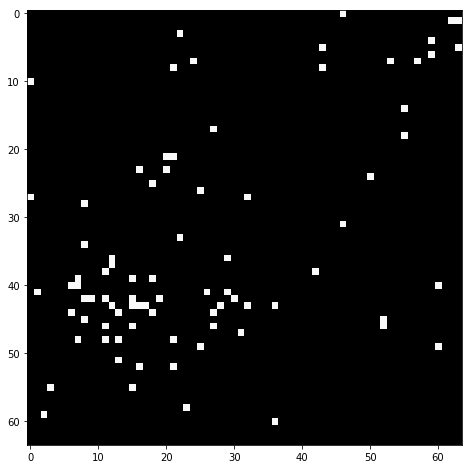

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import ndimage
file = './images/musician_BSOM_64_1000_305554.bmp'

image = ndimage.imread(file) 
plt.figure(figsize = (15,8))
plt.imshow(image)
image.shape

<h3>Export chunks of snippets to csv files</h3>

In [2]:
def create_chunk(chunck_size, total_chunck_size):
    current_chunk_id = db.get_current_chunk_id(cfg)[0][0]
    engine = create_engine('postgresql://postgres@localhost:5432/sparsenlp')
    sql = "select id, text from snippets where id >= "+str(current_chunk_id)+" and length(text) > 100 order by id limit "+str(total_chunck_size)
    df = pd.read_sql_query(sql, con=engine)

    current = 0
    while current < total_chunck_size + 1:

        df_chunk = df[current: current + chunck_size]
        df_chunk_min = df_chunk['id'].min()
        df_chunk_max = df_chunk['id'].max()
        if df_chunk.shape[0] > 0:
            id = db.create_chunk(cfg, df_chunk_min, df_chunk_max, df_chunk.shape[0])
            chunk_filename = str(id)+'_'+str(df_chunk_min)+'_'+str(df_chunk_max)+'_'+str(df_chunk.shape[0])
            df_chunk.to_csv('./chuncks/new/'+chunk_filename+'.bz2', index=False, compression='bz2', columns=['id', 'text'], encoding='utf-8')
            print (df_chunk.shape, df_chunk_min, df_chunk_max, chunk_filename)

        current += chunck_size

#create_chunk(10, 20)
create_chunk(10000, 200000)

(10000, 2) 780465 791784 32_780465_791784_10000
(10000, 2) 791785 803151 33_791785_803151_10000
(10000, 2) 803152 814309 34_803152_814309_10000
(10000, 2) 814310 825687 35_814310_825687_10000
(10000, 2) 825688 841072 36_825688_841072_10000
(10000, 2) 841077 853301 37_841077_853301_10000
(10000, 2) 853302 864829 38_853302_864829_10000
(10000, 2) 864832 876839 39_864832_876839_10000
(10000, 2) 876840 888780 40_876840_888780_10000
(10000, 2) 888781 900947 41_888781_900947_10000
(10000, 2) 900948 914225 42_900948_914225_10000
(10000, 2) 914226 926054 43_914226_926054_10000
(10000, 2) 926055 937677 44_926055_937677_10000
(10000, 2) 937678 949258 45_937678_949258_10000
(10000, 2) 949259 961087 46_949259_961087_10000
(10000, 2) 961088 972730 47_961088_972730_10000
(10000, 2) 972731 984446 48_972731_984446_10000
(10000, 2) 984447 996127 49_984447_996127_10000
(10000, 2) 996128 1007748 50_996128_1007748_10000
(10000, 2) 1007749 1019442 51_1007749_1019442_10000


<h3>Update database with tokens from chunk files</h3>

In [5]:

def update_tokens(_file=None):
    try:
        chunkfilesdir = "C:/AVS/ACADEMIC/ISCTE/TESE/andre/sparse-nlp/chuncks"
    except:
        print('ERROR: ' +str(sys.exc_info()[0]))
        
    if  _file is not None:
        
        if os.path.isfile(chunkfilesdir+'/processed/'+_file):
            print ('PROCESSING FILE: '+chunkfilesdir+'/processed/'+_file)
            with open(chunkfilesdir+'/processed/'+_file, 'r', encoding='utf-8') as f:
                reader = csv.reader(f)
                rownum = 0
                db.batch_update_cleaned_text_file(cfg, reader, _file)
            shutil.move(chunkfilesdir+'/processed/'+_file, chunkfilesdir+'/done/'+_file)
            update_stats()
        else:
            print ('FILE DOES NOT EXIST')
    else:
        for dirpath, dirnames, filenames in os.walk(chunkfilesdir+'/processed/'):
            allfiles = filenames
        for filename in allfiles:
            update_tokens(filename)
            

update_tokens('32_780465_791784_10000')
#update_tokens()


PROCESSING FILE: C:/AVS/ACADEMIC/ISCTE/TESE/andre/sparse-nlp/chuncks/processed/32_780465_791784_10000


In [10]:
data, vocabulary, freqs, word_counts_per_snippet = calculate_frequencies()

print (freqs['war'])
print ('------')
print (sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)[:5])
print ('------')
print (word_counts_per_snippet[5])
print ('------')
print("O vocabulário tem %d palavras"% len(vocabulary))

12943
------
[('id', 187689597180), ('the', 206265), ('include', 47477), ('time', 43436), ('state', 36749)]
------
Counter({'id': 608678, 'oil': 4, 'field': 2, 'divest': 2, 'interest': 2, 'the': 1, 'niger': 1, 'delta': 1, 'nembe': 1, 'creek': 1, 'discover': 1, 'produce': 1, 'middle': 1, 'miocene': 1, 'deltaic': 1, 'sandstone': 1, 'shale': 1, 'anticline': 1, 'structural': 1, 'trap': 1, 'depth': 1, 'shell': 1, 'announce': 1, 'strategic': 1, 'review': 1, 'operation': 1, 'nigeria': 1, 'hint': 1, 'asset': 1, 'while': 1, 'international': 1, 'company': 1, 'operate': 1, 'decades': 1, 'make': 1, 'move': 1, 'cite': 1, 'range': 1, 'issue': 1, 'include': 1, 'theft': 1, 'shell_oil_company': 1, 'say': 1, 'finalise': 1, 'nigerian': 1})
------
O vocabulário tem 262168 palavras


In [ ]:
#df_train = get_cleaned_data()
print (len(snippets_by_word['sunlight']))
#print (snippets_by_word['sunlight'][0:3])
#print (df_train.iloc[2497]['cleaned_text'])

H, W, N, rows = 64, 64, 1000, 305554    # Network height, width and unit dimensions
som_type = 'BSOM'
sufix = '_'+som_type+'_'+str(H)+'_'+str(N)+'_'+str(rows)
codebook = np.load('./serializations/codebook'+sufix+'.npy')
dataframe = pd.read_pickle('./serializations/dataframe'+sufix+'.pkl')
loader = np.load('./serializations/X'+sufix+'.npz')
print (' loading snippets_by_word'+sufix)   

som = Som(H, W, N, topology.RECT, verbose=True) # , verbose=True
som.codebook = codebook

#one possibility to speed up fingerprint generation is to pre-calculate bmus for each snippet (and save it to table)
#for idx, row in df_train.iterrows():
#    bmus = som.bmus(X[idx])
#    print (idx, bmus)
#    if idx > 100:
#        sys.exit(0)
    #idx = snippet_count['idx']
    #bmus = som.bmus(X[idx])